In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
data = pd.read_csv("TRAIN.csv")

In [ ]:
data.head()

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
0,0,1543203646318,Lyft,Boston University,Theatre District,3.03,1.0,Lux Black XL,34.0
1,1,1543203646319,Uber,South Station,Theatre District,1.30,1.0,Black,18.5
2,2,1543203646320,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5
3,3,1543203646320,Lyft,Northeastern University,Beacon Hill,2.43,1.0,Lyft,10.5
4,4,1543203646320,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0


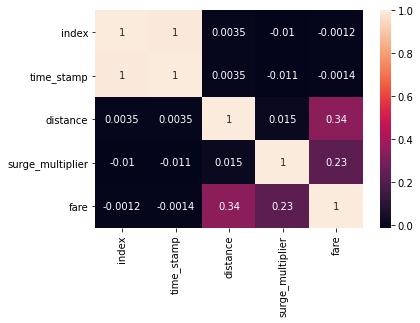

In [ ]:
import seaborn as sns
sns.heatmap(data.corr(), annot = True)

In [ ]:
data.drop(["time_stamp", "index"], axis = 1, inplace = True)

In [ ]:
data.head()

,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
0,Lyft,Boston University,Theatre District,3.03,1.0,Lux Black XL,34.0
1,Uber,South Station,Theatre District,1.30,1.0,Black,18.5
2,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5
3,Lyft,Northeastern University,Beacon Hill,2.43,1.0,Lyft,10.5
4,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0


In [ ]:
data["cab_provider"].value_counts()

Uber    14464
Lyft    13534
Name: cab_provider, dtype: int64

In [ ]:
data["destination"].value_counts()

Fenway                     2476
North End                  2434
Financial District         2404
West End                   2358
Beacon Hill                2348
Back Bay                   2311
Haymarket Square           2309
Boston University          2291
Northeastern University    2284
North Station              2273
Theatre District           2259
South Station              2251
Name: destination, dtype: int64

## some analytics

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
pallete = px.colors.qualitative.Dark24

In [ ]:
#popularity of cab providers
px.pie(names = data["cab_provider"].value_counts().index.tolist(), 
       values = data["cab_provider"].value_counts().values.tolist(),
       color = data["cab_provider"].value_counts().index.tolist(),
       title = "popularity of cab providers",
      color_discrete_sequence = pallete)

## SOME uber only insights

In [ ]:
uber_frame = data[data["cab_provider"] == "Uber"]
uber_frame.head()

,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
1,Uber,South Station,Theatre District,1.30,1.0,Black,18.5
2,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5
4,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0
5,Uber,Beacon Hill,North End,2.19,1.0,UberX,8.0
6,Uber,North Station,Fenway,3.05,1.0,WAV,10.5


In [ ]:
px.pie(names = uber_frame.cab_type.value_counts().index.tolist(),
       values = uber_frame.cab_type.value_counts().values.tolist(),
       color = uber_frame.cab_type.value_counts().index.tolist(),
       title = "popular uber cab types (wtf bro!)",
       color_discrete_sequence = pallete)

In [ ]:
from collections import defaultdict 
def popular_route(df):
  current_route = [df["source"][1],df["destination"][1]]
  route_dict = defaultdict(int)
  dist_dict = defaultdict(int)
  for source, destination, dist in zip(df['source'],df["destination"],df["distance"]):
    if source and destination in current_route:
      route_dict["-".join(current_route)] = route_dict["-".join(current_route)] + 1
    else:
      current_route = [source, destination]
      route_dict["-".join(current_route)] = route_dict["-".join(current_route)] + 1
      dist_dict["-".join(current_route)] = dist
  return pd.DataFrame(sorted(route_dict.items(), key = lambda x : x[1], reverse = True)),pd.DataFrame(sorted(dist_dict.items(), key = lambda x : x[1], reverse = True))

In [ ]:
pop_route, route_dist = popular_route(uber_frame)
uber_routes_dist = pd.merge(pop_route,route_dist, on = [0])
uber_routes_dist.columns = ["route", "pop","dist"]

In [ ]:
fig = px.bar(uber_routes_dist.iloc[:10,:], x = "route", y = "pop",
       color = "route",
       title = "TOP 10 popular routes by UBER", hover_data = ["dist"])
fig.update_layout(showlegend = False,
                  xaxis_title="routes",
                  yaxis_title="times route is travelled")

In [ ]:
uber_frame.surge_multiplier.value_counts()

1.0    14464
Name: surge_multiplier, dtype: int64

well, uber is not charging EXTRA

## SOME LYFT insights

In [ ]:
lyft_frame = data[data["cab_provider"] == "Lyft"].reset_index()
lyft_frame.head()

,index,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
0,0,Lyft,Boston University,Theatre District,3.03,1.00,Lux Black XL,34.0
1,3,Lyft,Northeastern University,Beacon Hill,2.43,1.00,Lyft,10.5
2,9,Lyft,Theatre District,Northeastern University,2.22,1.00,Shared,7.0
3,10,Lyft,Boston University,Financial District,4.46,1.75,Lux,47.5
4,11,Lyft,Boston University,Financial District,4.46,1.75,Lux Black,62.5


In [ ]:
lyft_frame.drop(["index"], axis = 1, inplace = True)

In [ ]:
px.pie(names = lyft_frame.cab_type.value_counts().index.tolist(),
       values = lyft_frame.cab_type.value_counts().values.tolist(),
       color = lyft_frame.cab_type.value_counts().index.tolist(),
       title = "popular lyft cab types (wtf bro! x2)",
       color_discrete_sequence = pallete)

In [ ]:
pop_route, route_dist = popular_route(lyft_frame)
lyft_routes_dist = pd.merge(pop_route,route_dist, on = [0])
lyft_routes_dist.columns = ["route", "pop","dist"]

In [ ]:
fig = px.bar(lyft_routes_dist.iloc[:10,:], x = "route", y = "pop",
       color = "route",
       title = "TOP 10 popular routes by LYFT", hover_data = ["dist"])
fig.update_layout(showlegend = False,
                  xaxis_title="routes",
                  yaxis_title="times route is travelled")

In [ ]:
px.pie(names = lyft_frame.surge_multiplier.value_counts().index.tolist(),
       values = lyft_frame.surge_multiplier.value_counts().values.tolist(),
       color = lyft_frame.surge_multiplier.value_counts().index.tolist(),
       color_discrete_sequence = pallete,title = "surge multiplier rates")

## Time for machine learning 

In [ ]:
data.drop(["source","destination"], axis = 1, inplace = True)

In [ ]:
data.isnull().sum()

cab_provider        1
distance            1
surge_multiplier    1
cab_type            1
fare                1
dtype: int64

In [ ]:
data.dropna(inplace = True)

In [ ]:
data["cab_provider"].replace(to_replace = data["cab_provider"].unique().tolist(), value = [*range(len(data["cab_provider"].unique().tolist()))],inplace = True)

In [ ]:
data["cab_type"].replace(to_replace = data["cab_type"].unique().tolist(), value = [*range(len(data["cab_type"].unique().tolist()))],inplace = True)

In [ ]:
data.head()

,cab_provider,distance,surge_multiplier,cab_type,fare
0,0,3.03,1.0,0,34.0
1,1,1.30,1.0,1,18.5
2,1,2.71,1.0,2,19.5
3,0,2.43,1.0,3,10.5
4,1,2.71,1.0,4,32.0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler() 

In [ ]:
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [ ]:
x = scaler_x.fit_transform(x)
y = scaler_y.fit_transform(y.reshape(-1,1))

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, random_state = 177013)

i will be trying 1 algo 

- GradientBoostingRegressor

XGboost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
XBR = GradientBoostingRegressor(n_estimators = 700)
XBR.fit(x_train,y_train.ravel())
y_pred_XBR = XBR.predict(x_test)
print(mean_squared_error(y_test,y_pred_XBR))

0.040125982059781844


## test data

In [ ]:
# test data 
test_data = pd.read_csv("TEST.csv")
test_data.head()

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type
0,0,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lux
1,1,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lux Black XL
2,2,1543364124206,Uber,Financial District,Fenway,6.83,1.0,UberX
3,3,1543364124206,Uber,Beacon Hill,Haymarket Square,1.35,1.0,UberXL
4,4,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lyft XL


In [ ]:
test_data.drop(["time_stamp","source", "destination","index"], axis = 1, inplace = True)

In [ ]:
test_data["cab_provider"].replace(to_replace = test_data["cab_provider"].unique().tolist(), value = [*range(len(test_data["cab_provider"].unique().tolist()))],inplace = True)
test_data["cab_type"].replace(to_replace = test_data["cab_type"].unique().tolist(), value = [*range(len(test_data["cab_type"].unique().tolist()))],inplace = True)

In [ ]:
test_data.head()

,cab_provider,distance,surge_multiplier,cab_type
0,0,0.59,1.0,0
1,0,0.59,1.0,1
2,1,6.83,1.0,2
3,1,1.35,1.0,3
4,0,0.59,1.0,4


In [ ]:
test_data_scale = scaler_x.transform(test_data)

In [ ]:
test_data_scale

array([[-8.79359447e-17,  5.90000000e-01,  1.00000000e+00,
        -1.09888208e-16],
       [-8.79359447e-17,  5.90000000e-01,  1.00000000e+00,
         1.00000000e+00],
       [ 1.00000000e+00,  6.83000000e+00,  1.00000000e+00,
         2.00000000e+00],
       ...,
       [ 1.00000000e+00,  3.05000000e+00,  1.00000000e+00,
         1.10000000e+01],
       [-8.79359447e-17,  2.96000000e+00,  1.00000000e+00,
         6.00000000e+00],
       [-8.79359447e-17,  2.96000000e+00,  1.00000000e+00,
        -1.09888208e-16]])

In [ ]:
y_pred_test = XBR.predict(test_data_scale)
sol = scaler_y.inverse_transform(y_pred_test)

In [ ]:
dict_1 = {"index": [*range(len(sol))],"fare": sol.tolist()}

In [ ]:
ans_here = pd.DataFrame(sol)
ans_here.head()

,0
0,10.615220
1,32.070159
2,25.127091
3,19.747625
4,15.679024


In [ ]:
ans_way = pd.read_csv("TEST.csv")

In [ ]:
ans_way.head()

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type
0,0,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lux
1,1,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lux Black XL
2,2,1543364124206,Uber,Financial District,Fenway,6.83,1.0,UberX
3,3,1543364124206,Uber,Beacon Hill,Haymarket Square,1.35,1.0,UberXL
4,4,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lyft XL


In [ ]:
ans_way.columns[1:].tolist()

['time_stamp',
 'cab_provider',
 'source',
 'destination',
 'distance',
 'surge_multiplier',
 'cab_type']

In [ ]:
ans_way.drop(ans_way.columns[1:].tolist(), axis = 1, inplace = True)

In [ ]:
ans_way["fare"] = sol

In [ ]:
ans_way.to_csv("carpricepred_2.csv",index = False)

In [ ]:
sample = pd.read_csv("sample_submission.csv")